## Fitness Tracker Analysis - Part 4

**Continued from Part 3 here:**

`/notebooks/nk-fitness-tracker-p3-feature-engineering.ipynb`

### 4.1 - Predictive Modeling

Using the preprocessed data, the following tasks in this notebook will cover:

- Feature selection
- Model testing and selection
- Hyperparameter tuning with grid search

Towards the end, the model with the highest accuracy will be selected as the final model.

Set up the project below:

In [1]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import src.visualization.visualize as vis
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from src.models.LearningAlgorithms import ClassificationAlgorithms

In [2]:
# Configure the plot settings
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [3]:
# Read in the processed data file
df = pd.read_pickle("data/interim/03_data_preprocessed.pkl")

### 4.2 - Split the Data Into Training and Test Sets

First, remove features we don't need - such as participant, category, and set:

In [4]:
df_train = df.drop(["participant", "category", "set"], axis=1)

Given that `label` is the target variable, drop that column from the training set and assign it to the variable `y`:

In [5]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

Then split the dataset into a training set and a test set using a 75/25 ratio. Be sure to set the `random_state` to an integer for reproducibility.

Also set stratify to `y` to ensure that the label distribution is equal in both training and test sets to minimize bias.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Next, double check that the distribution of the labels is roughly equal in the training and test sets:

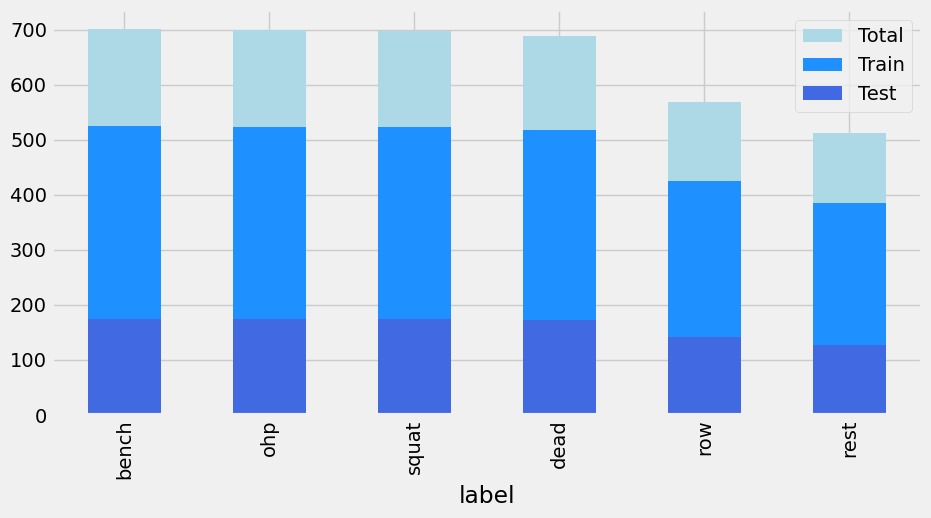

In [7]:
vis.plot_stratification_on_labels(df_train, y_train, y_test)

### 4.3 - Create Feature Groups to Test Models With

In the full dataset, we have over a hundred features and it's not yet known which feature engineering methods are most beneficial. Instead of lumping all features into the model, we'll test each group to see which methods helped the models the most. 

The feature groups are as follows:

- **Original features:** Original six predictor columns (x, y, z) of accelerometer and gyroscope data.

- **Scalar features:** The scalars of accelerometer and gyroscope motions.

- **PCA features:** The components derived from the Principal Component Analysis dimensionality reduction technique.

- **Temporal features:** The rolling averages on the basic and scalar features, as well as standard deviations for each rolling window.

- **Frequency features:** The frequency components of the original and scalar features using Discrete Fourier Transformation.

- **Cluster features:** A cluster feature derived from the KMeans model.

For a review on these methods, please see `/notebooks/nk-fitness-tracker-p3-feature-engineering.ipynb`


In [8]:
# Group the feature columns into feature subsets:
orig_features = ["acc_x", "acc_y", "acc_z", "gyr_x", "gyr_y", "gyr_z"]
scalar_features = ["acc_r", "gyr_r"]
pca_features = ["pca_1", "pca_2", "pca_3"]
time_features = [f for f in df_train.columns if "_temp_" in f]
frequency_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]
cluster_features = ["cluster"]

Check how many features are in each subset:

In [9]:
print("Original features: ", len(orig_features))
print("Scalar features: ", len(scalar_features))
print("PCA features: ", len(pca_features))
print("Time features: ", len(time_features))
print("Frequency features: ", len(frequency_features))
print("Cluster features: ", len(cluster_features))

Original features:  6
Scalar features:  2
PCA features:  3
Time features:  16
Frequency features:  88
Cluster features:  1


Now group features into four sets:

In [10]:
feature_set_1 = list(set(orig_features))
feature_set_2 = list(set(feature_set_1 + scalar_features + pca_features))
feature_set_3 = list(set(feature_set_2 + time_features))
feature_set_4 = list(set(feature_set_3 + frequency_features + cluster_features))

### 4.4 - Forward Feature Selection

Now we'll find the 10 best features to use in the model using a decision tree by looping through the full dataset.

In [11]:
# Create an instance of the ClassificationAlgorithms class
learner = ClassificationAlgorithms()

# Set the maximum number of features for selection
max_features = 10

Run the decision tree algorithm (only need to be run once).

**Warning: This will take a long time to run (around 5-7 minutes)**

In [12]:
# selected_features, ordered_features, ordered_scores = learner.forward_selection(
#     max_features, X_train, y_train
# )

Now check which features have been found to be the best and display their scores on a graph:

In [13]:
# ordered_features

In [14]:
# Recorded from last run so we don't have to run the scoring cell again
ordered_scores = [
    0.8879696656325405,
    0.9762150982419855,
    0.9979317476732161,
    0.9996552912788693,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0
 ]

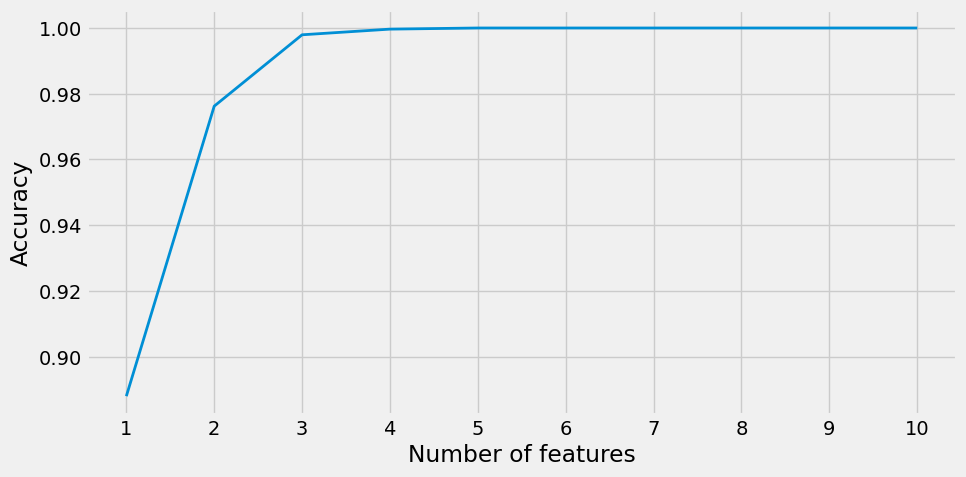

In [15]:
vis.plot_accuracy_curve(ordered_scores, max_features)

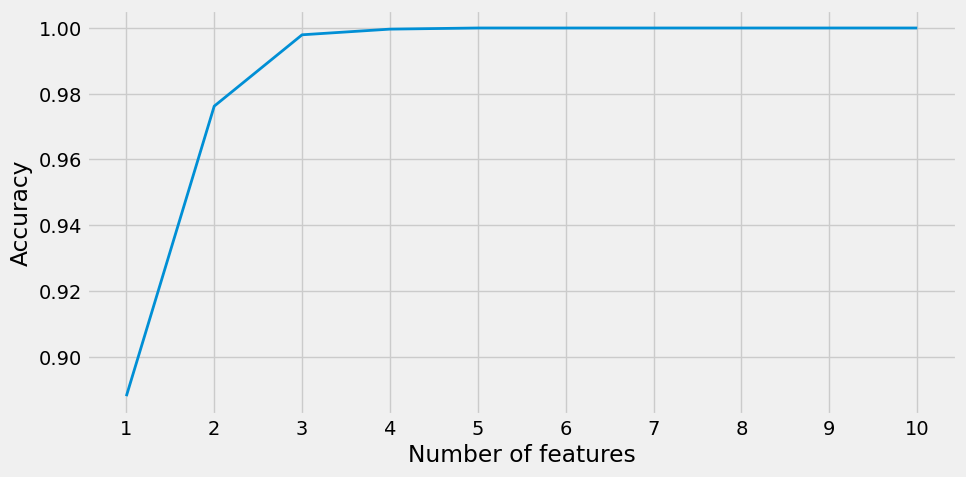

It appears that the PCA and Fourier Transformation methods created very powerful features that brings accuracy close to 100% within just a few features. We'll use these 10 features as the selected group in modeling. 

In [16]:
selected_features = [
    'pca_1',
    'set_duration',
    'acc_x_freq_0.0_Hz_ws_14',
    'acc_y_freq_0.0_Hz_ws_14',
    'acc_z_freq_0.357_Hz_ws_14',
    'acc_r_max_freq',
    'gyr_r_freq_2.5_Hz_ws_14',
    'acc_r_freq_weighted',
    'acc_z_temp_mean_ws_5',
    'gyr_x_pse'
 ]

### 4.5 - Hyperparameter Grid Search

Now run a grid search on the best hyperparameters on all models EXCEPT Neural Networks and XGBoost. 

*Reason: NN takes a long time with grid search, and XGBoost is prone to overfitting.*

First group each feature set and name them:

In [17]:
possible_feature_sets = [
    feature_set_1,
    feature_set_2,
    feature_set_3,
    feature_set_4,
    selected_features,
]

feature_names = [
    "Feature Set 1",
    "Feature Set 2",
    "Feature Set 3",
    "Feature Set 4",
    "Selected Features",
]

Now execute the grid search and obtain the scores:

**NOTE: Even with only one iteration (set `iterations` to 1), this cell will run for a while, give it at least 5 minutes...**

In [18]:
## The following refactoring attempt resulted in an endless loop, commenting out for further investigation
# import src.models.train_model as model
# iterations = 1
# score_df = model.run_grid_search(X_train, X_test, possible_feature_sets, feature_names, iterations)

## For now, stick with what's working below
iterations = 1

def run_grid_search(X_train, X_test, possible_feature_sets, feature_names, iterations):
    score_df = pd.DataFrame()
    for i, f in zip(range(len(possible_feature_sets)), feature_names):

        print("Feature set:", str(i + 1))
        selected_train_X = X_train[possible_feature_sets[i]]
        selected_test_X = X_test[possible_feature_sets[i]]

        # First run non deterministic classifiers to average their score.
        performance_test_nn = 0
        performance_test_rf = 0

        for it in range(0, iterations):
            print("\tTraining neural network,", it)
            (
                class_train_y,
                class_test_y,
                class_train_prob_y,
                class_test_prob_y,
            ) = learner.feedforward_neural_network(
                selected_train_X,
                y_train,
                selected_test_X,
                gridsearch=False,
            )
            performance_test_nn += accuracy_score(y_test, class_test_y)

            print("\tTraining random forest,", it)
            (
                class_train_y,
                class_test_y,
                class_train_prob_y,
                class_test_prob_y,
            ) = learner.random_forest(
                selected_train_X, y_train, selected_test_X, gridsearch=True
            )
            performance_test_rf += accuracy_score(y_test, class_test_y)

        performance_test_nn = performance_test_nn / iterations
        performance_test_rf = performance_test_rf / iterations

        # And we run our deterministic classifiers:
        print("\tTraining KNN")
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.k_nearest_neighbor(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_knn = accuracy_score(y_test, class_test_y)

        print("\tTraining decision tree")
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.decision_tree(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_dt = accuracy_score(y_test, class_test_y)

        print("\tTraining naive bayes")
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

        performance_test_nb = accuracy_score(y_test, class_test_y)

        print("\tTraining XGBoost")
        # First encode the labels in the train_y table
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_train)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.xgboost_classifier(
            selected_train_X, y_encoded, selected_test_X
        )  # add gridsearch later

        class_test_y = le.inverse_transform(class_test_y)
        performance_test_xgb = accuracy_score(y_test, class_test_y)

        # Save results to dataframe
        print("\tSaving results to dataframe")
        models = ["NN", "RF", "KNN", "DT", "NB", "XGB"]
        new_scores = pd.DataFrame(
            {
                "model": models,
                "feature_set": f,
                "accuracy": [
                    performance_test_nn,
                    performance_test_rf,
                    performance_test_knn,
                    performance_test_dt,
                    performance_test_nb,
                    performance_test_xgb,
                ],
            }
        )
        score_df = pd.concat([score_df, new_scores])
    
    return score_df
        
score_df = run_grid_search(X_train, X_test, possible_feature_sets, feature_names, iterations)

Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
	Saving results to dataframe
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
	Saving results to dataframe
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
	Saving results to dataframe
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
	Saving results to dataframe
Feature set: 5
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
	Training XGBoost
	Saving results to dataframe


Show and compare results in a grouped bar plot:

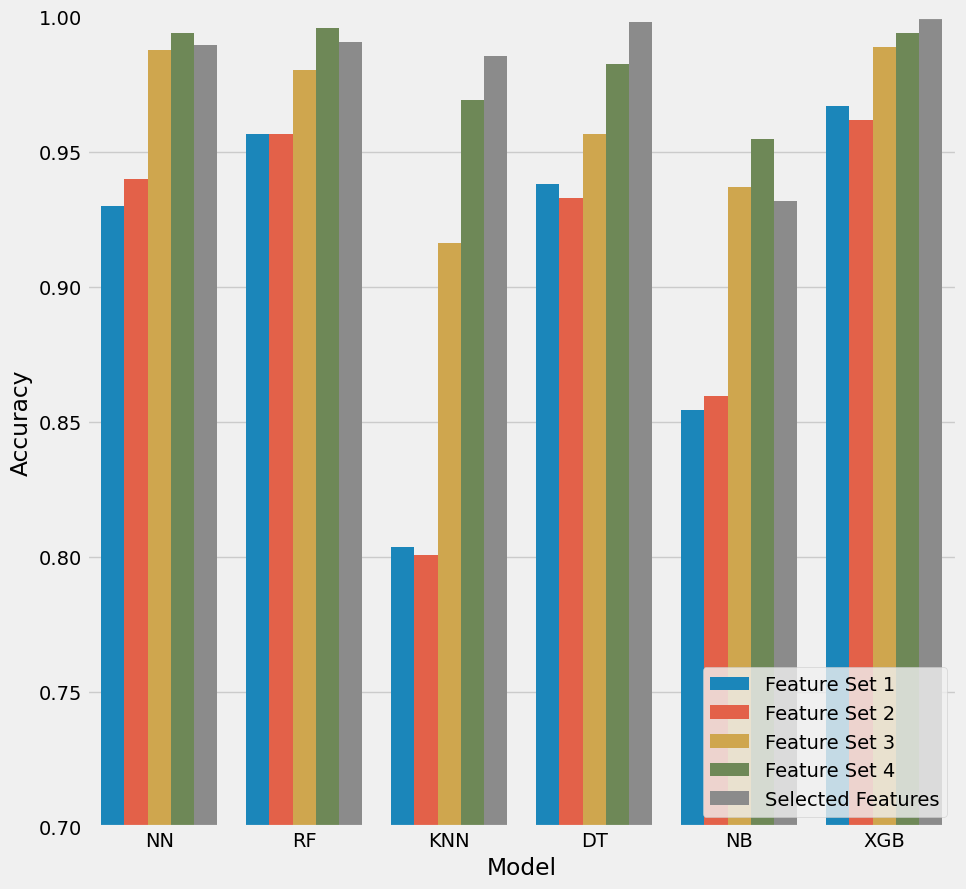

In [19]:
score_df.sort_values(by="accuracy", ascending=False)
vis.plot_model_accuracy_comparison(score_df)

Plot shows that the random forest performs best with the selected features, and neural networks performed best with feature set 4. Test the RF model using the test set with the selected features to see how well it generalizes to unfamiliar data.

**Update - XGBoost model performed very well with selected features even without a grid search**

### 4.6 - Compare Model Performance Using Confusion Matrix

The following models have been selected for further evaluation using confusion matrices:

- Decision Tree with selected features
- Random Forest with selected features
- Neural Networks with feature set 4
- XGBoost with selected features

#### 4.6.1 - Decision Tree with Selected Features

Using selected features, we'll test the decision tree model and print the accuracy score:

In [20]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.decision_tree(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)

# Get accuracy score
accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

0.9968976215098242


Accuracy scores aren't necessarily best indicators of performance for classification algorithms. For that, we'll want to see the confusion matrix:

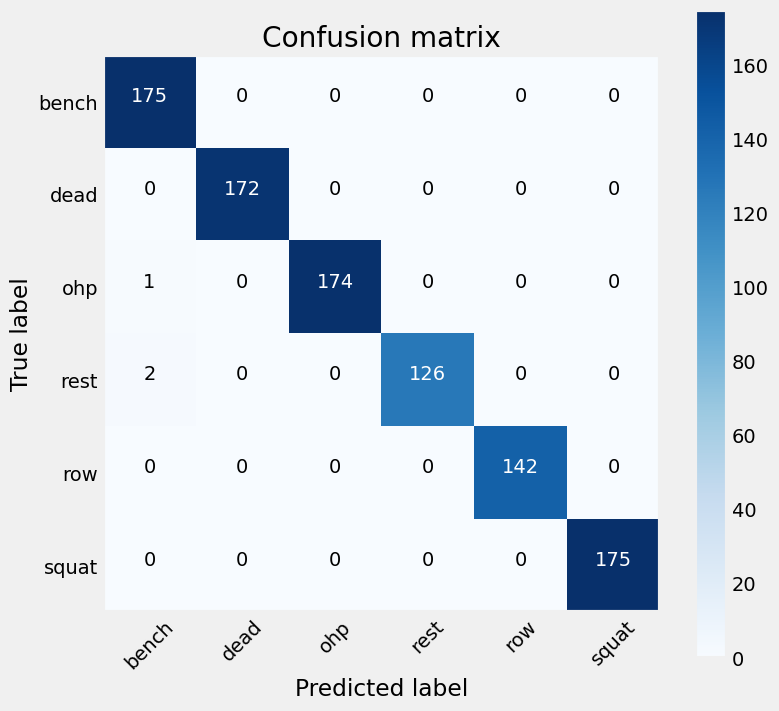

In [21]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

vis.plot_confusion_matrix(cm, classes)

The confusion matrix is nearly perfect with only 3 misclassification errors involving overhead press and bench press. The accuracy score seems too good, which points to possible target leakage. 

To prevent target leakage, we can try selecting a train/test set based on participant:

In [22]:
participant_df = df.drop(["set", "category"], axis=1)

X_train = participant_df[participant_df["participant"] != "A"].drop("label", axis=1)
y_train = participant_df[participant_df["participant"] != "A"]["label"]

X_test = participant_df[participant_df["participant"] == "A"].drop("label", axis=1)
y_test = participant_df[participant_df["participant"] == "A"]["label"]

X_train = X_train.drop(["participant"], axis=1)
X_test = X_test.drop(["participant"], axis=1)

Make sure the training and test sets are stratified:

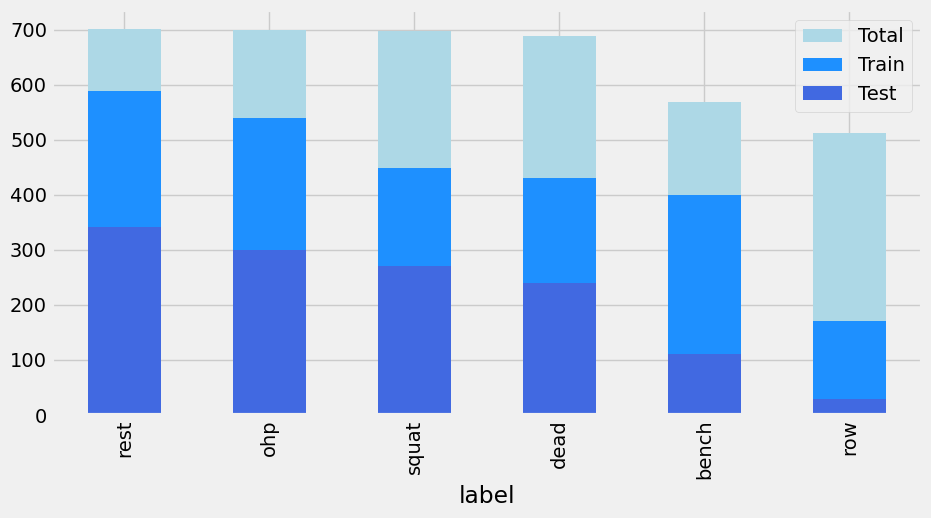

In [23]:
vis.plot_stratification_on_labels(df_train, y_train, y_test)

Rerun the decision tree model on the new training and test sets:

0.9698142414860681


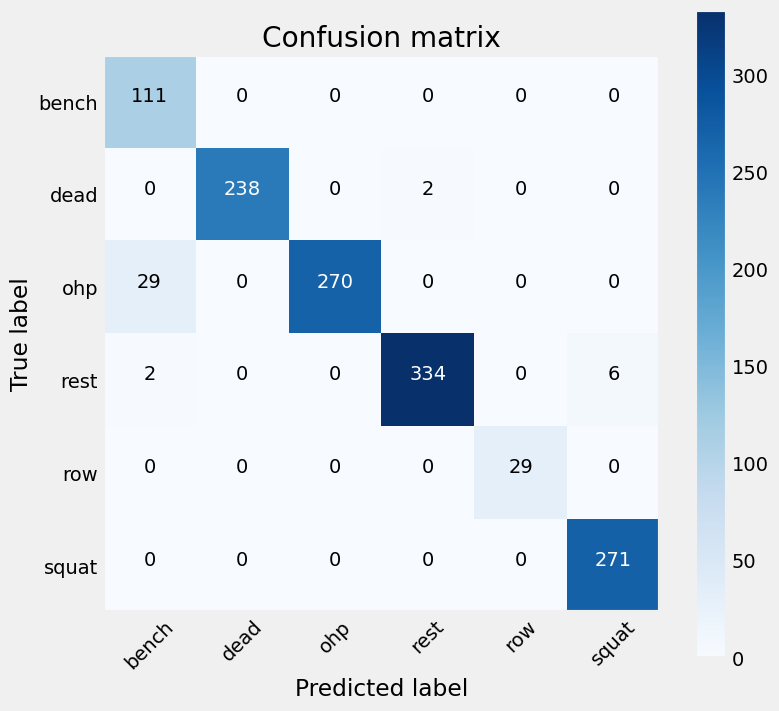

In [24]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.decision_tree(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)
vis.plot_confusion_matrix(cm, classes)

This time, the accuracy score is lower at 96.9%, and it performs worse particularly by misclassifying overhead presses as bench presses.


#### 4.6.2 - Random Forest with Selected Features

Given that the decision tree didn't generalize well to an individual participant's data when doing overhead presses, we should try another model to see if it works better. This time, the random forest model will be used:

0.9690402476780186


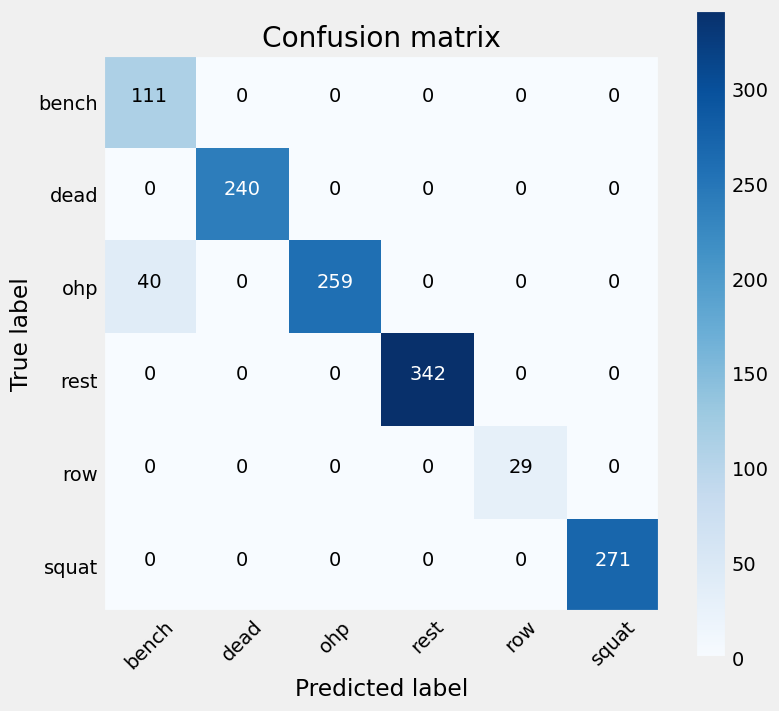

In [25]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[selected_features], y_train, X_test[selected_features], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)
vis.plot_confusion_matrix(cm, classes)

Even with similar accuracy, the random forest model performs even worse with the same group of features on classifying overhead presses. 

Repeat this test with feature set 4:

#### 4.6.3 - Random Forest with Feature Set 4

0.9907120743034056


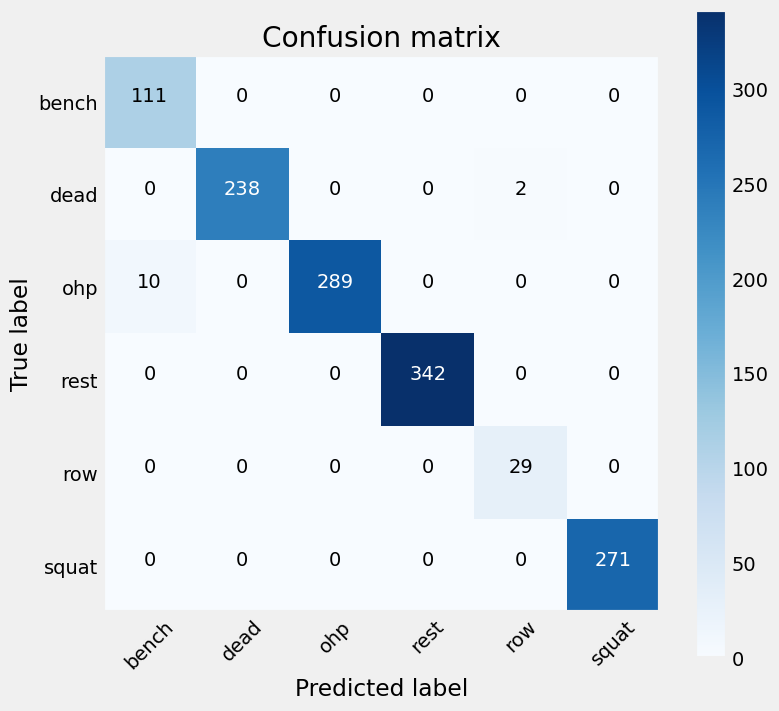

In [26]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.random_forest(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)
vis.plot_confusion_matrix(cm, classes)

Using feature set 4, the random forest performs much better in classifying overhead presses properly. 

However, there are slight errors with classifying rest as overhead presses and deadlifts as rows, respectively. The latter errors aren't too significant, but bears testing other models.

#### 4.6.4 - Neural Networks with Feature Set 4

Neural networks achieved a high accuracy score particularly with feature set 4, so it's worth exploring with a confusion matrix:

In [27]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.feedforward_neural_network(
    X_train[feature_set_4], y_train, X_test[feature_set_4], gridsearch=True
)

accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)
vis.plot_confusion_matrix(cm, classes)

Although neural networks performed somewhat betteer than random forest, it still misclassified overhead presses as bench presses in 7 instances. 

While it corrected the other errors the random forest model made, neural networks takes a long time to run and takes up a large amount of compute resources.

For that reason, a simpler model that takes up less resources would be more cost effective here. Next step is to try XGBoost and compare.

#### 4.6.5 - XGBoost Classifier with Selected Features

One important difference between XGBoost and the other models is that the labels need to be encoded into numerical values before running the model.

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)

(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.xgboost_classifier(
    X_train[selected_features], y_encoded, X_test[selected_features]
)

class_test_y = le.inverse_transform(class_test_y)
accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

classes = le.inverse_transform(class_test_prob_y.columns)
cm = confusion_matrix(y_test, class_test_y, labels=classes)
vis.plot_confusion_matrix(cm, classes)

XGBoost with selected features performs well on all classifications except for overhead presses, which it still misclassifies as bench presses. 

Rerun XGBoost with feature set 4:

#### 4.6.6 - XGBoost Classifier with Feature Set 4

The label encoder has already been called once, so no need to call it again.

In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y,
) = learner.xgboost_classifier(
    X_train[feature_set_4], y_encoded, X_test[feature_set_4]
)

class_test_y = le.inverse_transform(class_test_y)
accuracy = accuracy_score(y_test, class_test_y)
print(accuracy)

classes = le.inverse_transform(class_test_prob_y.columns)
cm = confusion_matrix(y_test, class_test_y, labels=classes)
vis.plot_confusion_matrix(cm, classes)

XGBoost does a solid job with feature set 4, which indicates that the selected features may not be the best set of features for classifying overhead presses. 

Either the hyperparameters need to be fine-tuned with a grid search on XGBoost, or a new set of selected features should be used. In other model tests, I found that this group of selected features has gotten better results on all models, reducing the classification error on overhead presses:

#### 4.7 - Selected Features with Potential for Better Results

In [ ]:
selected_features = [
    "acc_y_freq_0.0_Hz_ws_14",
    "gyr_r_freq_0.0_Hz_ws_14",
    "set_duration",
    "acc_z_freq_0.0_Hz_ws_14",
    "cluster",
    "gyr_z_freq_2.5_Hz_ws_14",
    "gyr_x_freq_1.429_Hz_ws_14",
    "gyr_z",
    "gyr_z_freq_1.786_Hz_ws_14",
    "acc_z_freq_0.357_Hz_ws_14",
]

Feel free to repeat the above tests in section 4.6 using the above group of features and see if you get a better score and confusion matrix. 